# Data Assimilation with GPS Data

This project demonstrates the Ensemble Kalman Filter (EnKF) using real GPS data procured from two phones measuring the location of the same thing (me driving my car around a parking lot). It is meant as a hands-on experience in overcoming each obstacle of real-world data assimilation, including asynchronous and irregularly-spaced observations that don't directly map to the timing of the state model, and obtaining a solid initial $\mathbf{R}$ matrix. The second issue is determining the accuracy of the model - for my case, I was able to make an approximate "true" solution by mapping out my route using an online tool. 

<img src = "../img/routes.png" height = 300 width = 300/>

## Plotting the observations

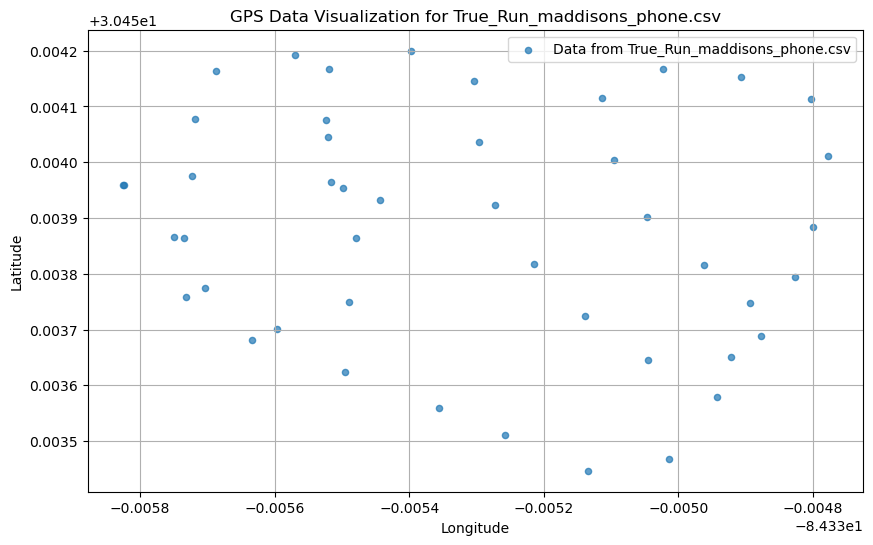

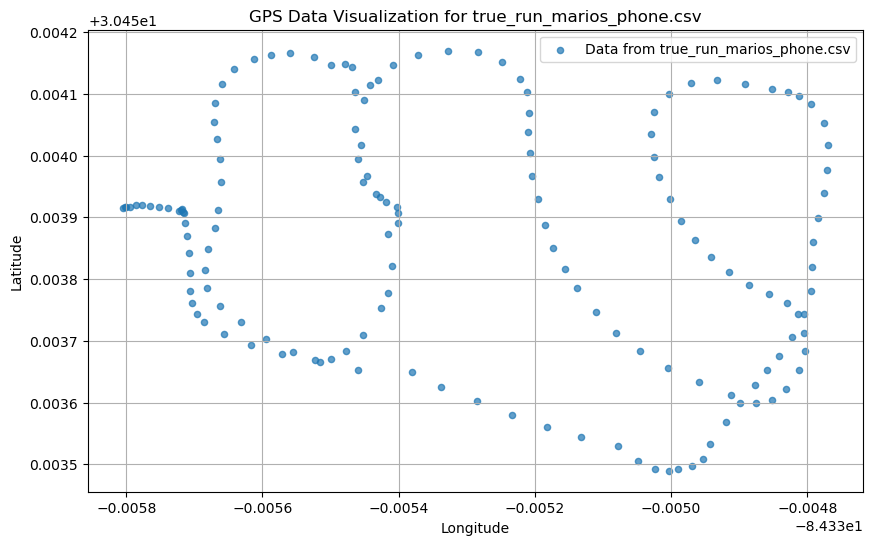

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_gps_data(file_path):
    # Load data
    data = pd.read_csv(file_path)
    
    latitudes = data['Latitude']
    longitudes = data['Longitude']

    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(longitudes, latitudes, alpha=0.7, marker='o', s=20, label=f'Data from {file_path.split("/")[-1]}')
    plt.title(f'GPS Data Visualization for {file_path.split("/")[-1]}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.legend()
    plt.show()

# Paths to the datasets
mm_file_path = '../data/True_Run_maddisons_phone.csv'
ms_file_path = '../data/true_run_marios_phone.csv'

# Plotting each dataset
plot_gps_data(mm_file_path)
plot_gps_data(ms_file_path)


## Interpolating the observations

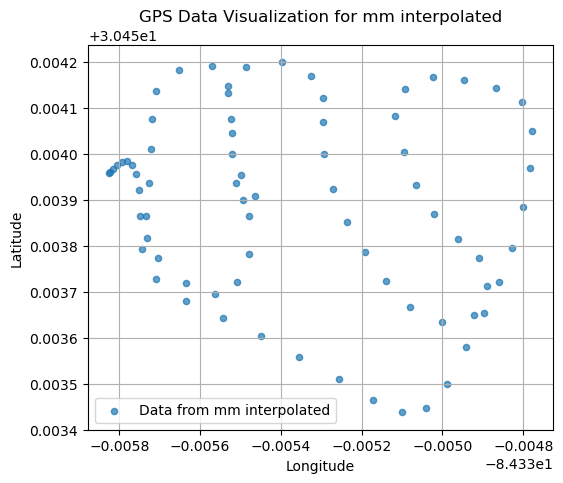

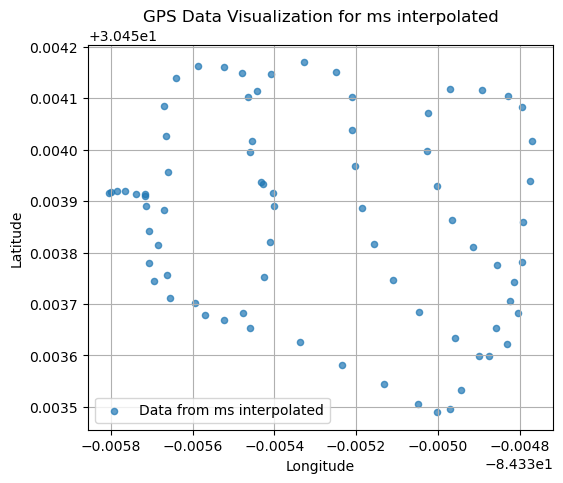

In [24]:
from scipy.interpolate import interp1d
import numpy as np

def interpolate_gps_data(file_path, freq='2s', method='linear'):
    # Load data
    data = pd.read_csv(file_path)
    
    # Strip off any irregular timezone strings and convert to datetime
    data['Datetime'] = data['Datetime'].str.slice(stop=-3)
    data['Datetime'] = pd.to_datetime(data['Datetime'], format='%Y/%m/%d %H:%M:%S', errors='coerce')
    
    # Set as index
    data.set_index('Datetime', inplace=True)
    
    # Trim data to remove leading/trailing NaNs in resampling
    data = data[~data['Longitude'].isna()]
    start, end = data.index.min(), data.index.max()

    # Resample within the data range
    data_resampled = data.resample(freq).interpolate(method=method)
    
    # If linear interpolation leaves NaNs, consider using spline for larger gaps
    if data_resampled.isna().any().any() and method == 'linear':
        # Create an interpolation function based on existing data points
        # Using time in seconds since the start for spline interpolation
        time_seconds = (data.index - start).total_seconds()
        spline_func_lon = interp1d(time_seconds, data['Longitude'], kind='cubic', fill_value="extrapolate")
        spline_func_lat = interp1d(time_seconds, data['Latitude'], kind='cubic', fill_value="extrapolate")
        
        # Create a new time index for resampling and interpolate
        freq_seconds = int(freq[:-1])  # Extract numerical part and convert to int
        new_time_index = np.arange(time_seconds[0], time_seconds[-1] + 1, freq_seconds)
        new_datetimes = [start + pd.Timedelta(seconds=int(sec)) for sec in new_time_index]
        
        longitude_interp = spline_func_lon(new_time_index)
        latitude_interp = spline_func_lat(new_time_index)
        
        data_resampled = pd.DataFrame({'Longitude': longitude_interp, 'Latitude': latitude_interp}, index=new_datetimes)

    return data_resampled

# Paths to the datasets
mm_file_path = '../data/True_Run_maddisons_phone.csv'
ms_file_path = '../data/True_run_marios_phone.csv'

# Interpolate each dataset, trying cubic spline if linear leaves NaNs
mm_resampled = interpolate_gps_data(mm_file_path, method='linear')
ms_resampled = interpolate_gps_data(ms_file_path, method='linear')

# Check the data format and extract coordinates
    # Assuming 'lat' and 'long' columns for Maddison's phone data
def plot_gps_data(data, name):
    latitudes = data['Latitude']
    longitudes = data['Longitude']


    # Create a scatter plot
    plt.figure(figsize=(6, 5))
    plt.scatter(longitudes, latitudes, alpha=0.7, marker='o', s=20, label=f'Data from {name}')
    plt.title(f'GPS Data Visualization for {name}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.legend()
    plt.show()

# Plotting each dataset
plot_gps_data(mm_resampled, 'mm interpolated')
plot_gps_data(ms_resampled, 'ms interpolated')

## Generating the $\mathbf{R}$ matrix
Here, I logged the GPS at values without moving position, allowing me to see the variability in the observations. From this, we derive the $\mathbf{R}$ matrix.

In [29]:
def generate_R(data):
    """ Generate R matrix from provided DataFrame """
    variance_longitude = data['Longitude'].var()
    variance_latitude = data['Latitude'].var()
    covariance_lat_lon = data['Latitude'].cov(data['Longitude'])
    return np.array([[variance_latitude, covariance_lat_lon],
                     [covariance_lat_lon, variance_longitude]])

def calculate_cross_covariance(data1, data2):
    """ Calculate cross-covariance between two data sources """
    covariance_lat1_lat2 = data1['Latitude'].cov(data2['Latitude'])
    covariance_lon1_lon2 = data1['Longitude'].cov(data2['Longitude'])
    covariance_lat1_lon2 = data1['Latitude'].cov(data2['Longitude'])
    covariance_lon1_lat2 = data1['Longitude'].cov(data2['Latitude'])
    return np.array([[covariance_lat1_lat2, covariance_lat1_lon2],
                     [covariance_lon1_lat2, covariance_lon1_lon2]])

# Generate R matrices for each resampled dataset
R_mm = generate_R(mm_resampled)
R_ms = generate_R(ms_resampled)

# Calculate cross-covariance matrix for the observations between resampled datasets
R_cross = calculate_cross_covariance(mm_resampled, ms_resampled)

# Construct the combined R matrix with cross-covariances
R_combined = np.block([
    [R_mm, R_cross],
    [R_cross.T, R_ms]
])
# remove nans
R_combined = np.nan_to_num(R_combined)

print("Combined R Matrix with Cross-Correlation:")
print(R_combined)


Combined R Matrix with Cross-Correlation:
[[ 4.15034576e-08 -1.38941408e-08  0.00000000e+00  0.00000000e+00]
 [-1.38941408e-08  1.09911504e-07  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.63864452e-08 -1.48852484e-08]
 [ 0.00000000e+00  0.00000000e+00 -1.48852484e-08  1.13572062e-07]]


## Stochastic Ensemble Kalman Filter

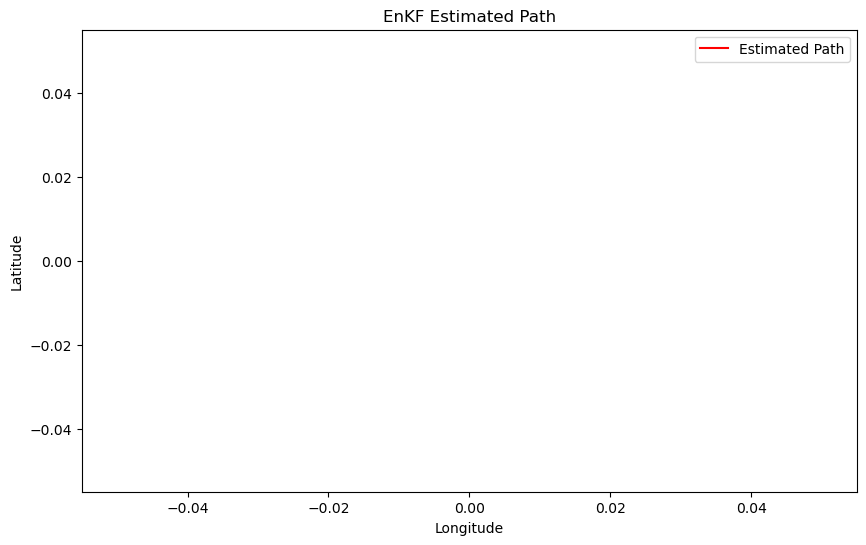

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class EnsembleKalmanFilter:
    def __init__(self, initial_state, ensemble_size, R, Q, P):
        self.ensemble_size = ensemble_size
        self.states = np.array([initial_state + np.random.multivariate_normal(np.zeros(len(initial_state)), P) for _ in range(ensemble_size)])
        self.R = R  # Observation error covariance matrix
        self.Q = Q  # Model error covariance matrix
    
    def predict(self, model):
        """ Predict future state with the model and add process noise """
        self.states = np.array([model(state) for state in self.states]) + np.random.multivariate_normal(np.zeros(self.states.shape[1]), self.Q, self.ensemble_size)
    
    def update(self, observation, H):
        """ Update the ensemble based on the observation """
        mean = np.mean(self.states, axis=0)
        P_forecast = np.cov(self.states, rowvar=False) + self.Q
        K = P_forecast @ H.T @ np.linalg.inv(H @ P_forecast @ H.T + self.R)
        observations_perturbed = [observation + np.random.multivariate_normal(np.zeros(len(observation)), self.R) for _ in range(self.ensemble_size)]
        self.states += K @ (observations_perturbed - (H @ self.states.T).T)

    def get_state_estimate(self):
        """ Return the current estimate of the state """
        return np.mean(self.states, axis=0)

def simple_model(state):
    """ Simple identity model, assuming state does not change significantly """
    return state

# Initialize the filter
ensemble_size = 100
initial_state = [np.mean(mm_resampled['Longitude']), np.mean(mm_resampled['Latitude'])]
Q = np.diag([1e-4, 1e-4])  # Example process noise covariance matrix
P = np.diag([1e-4, 1e-4])  # Initial estimate error covariance

enkf = EnsembleKalmanFilter(initial_state, ensemble_size, R_combined, Q, P)

estimated_states = []

# Using zip to iterate through both datasets assuming they are aligned
for (index_mm, row_mm), (index_ms, row_ms) in zip(mm_resampled.iterrows(), ms_resampled.iterrows()):
    observation_mm = [row_mm['Longitude'], row_mm['Latitude']]
    observation_ms = [row_ms['Longitude'], row_ms['Latitude']]
    observation_combined = np.concatenate([observation_mm, observation_ms])
    H = np.eye(len(observation_combined))  # Identity matrix sized to combined observation vector
    
    enkf.predict(simple_model)
    enkf.update(observation_combined, H)
    
    # Capture the estimated state after the update
    estimated_state = enkf.get_state_estimate()
    estimated_states.append(estimated_state)

# Plotting the estimated state
plt.figure(figsize=(10, 6))
plt.plot([state[0] for state in estimated_states], [state[1] for state in estimated_states], 'r-', label='Estimated Path')
plt.scatter(mm_resampled['Longitude'], mm_resampled['Latitude'], c='b', marker='o', label='MM Resampled')
plt.scatter(ms_resampled['Longitude'], ms_r


Final Estimated States: []


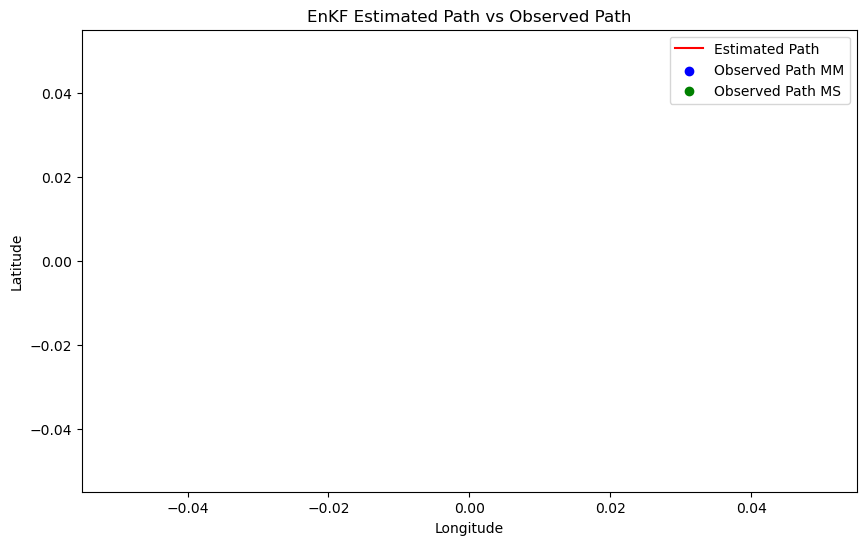

In [35]:
# Generate common index after ensuring both datasets are resampled and have DateTime index
common_index = mm_resampled.index.intersection(ms_resampled.index)

# Initialize the filter
ensemble_size = 100
initial_state = [np.mean(mm_resampled.loc[common_index, 'Longitude']), np.mean(mm_resampled.loc[common_index, 'Latitude'])]
Q = np.diag([1e-4, 1e-4])  # Example process noise covariance matrix
P = np.diag([1e-4, 1e-4])  # Initial estimate of error covariance matrix

enkf = EnsembleKalmanFilter(initial_state, ensemble_size, R_combined, Q, P)

estimated_states = []  # Initialize an empty list to store state estimates

# Run the filter with combined interpolated data
for timestamp in common_index:
    obs_mm = mm_resampled.loc[timestamp]
    obs_ms = ms_resampled.loc[timestamp]
    observation_combined = np.concatenate([obs_mm, obs_ms])
    H = np.eye(len(observation_combined))  # Identity matrix sized to combined observation vector

    enkf.predict(simple_model)  # Predict step
    enkf.update(observation_combined, H)  # Update step

    # Retrieve and store the current state estimate after the update
    current_state_estimate = enkf.get_state_estimate()
    estimated_states.append(current_state_estimate)  # Append current state estimate to the list

# Ensure estimated_states is now populated with the state estimates from each time step
print("Final Estimated States:", np.array(estimated_states))

# Plotting the estimated states
plt.figure(figsize=(10, 6))
plt.plot([state[0] for state in estimated_states], [state[1] for state in estimated_states], 'r-', label='Estimated Path')
plt.scatter(mm_resampled['Longitude'], mm_resampled['Latitude'], c='b', label='Observed Path MM')
plt.scatter(ms_resampled['Longitude'], ms_resampled['Latitude'], c='g', label='Observed Path MS')
plt.title('EnKF Estimated Path vs Observed Path')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()